Nunez seems to miss all the easy chances and score difficult ones, lets use xG as a metric for how "difficult" the chances are and compare shots scored vs missed

While looking for xG data I found this awesome source for xG data for each shot taken:

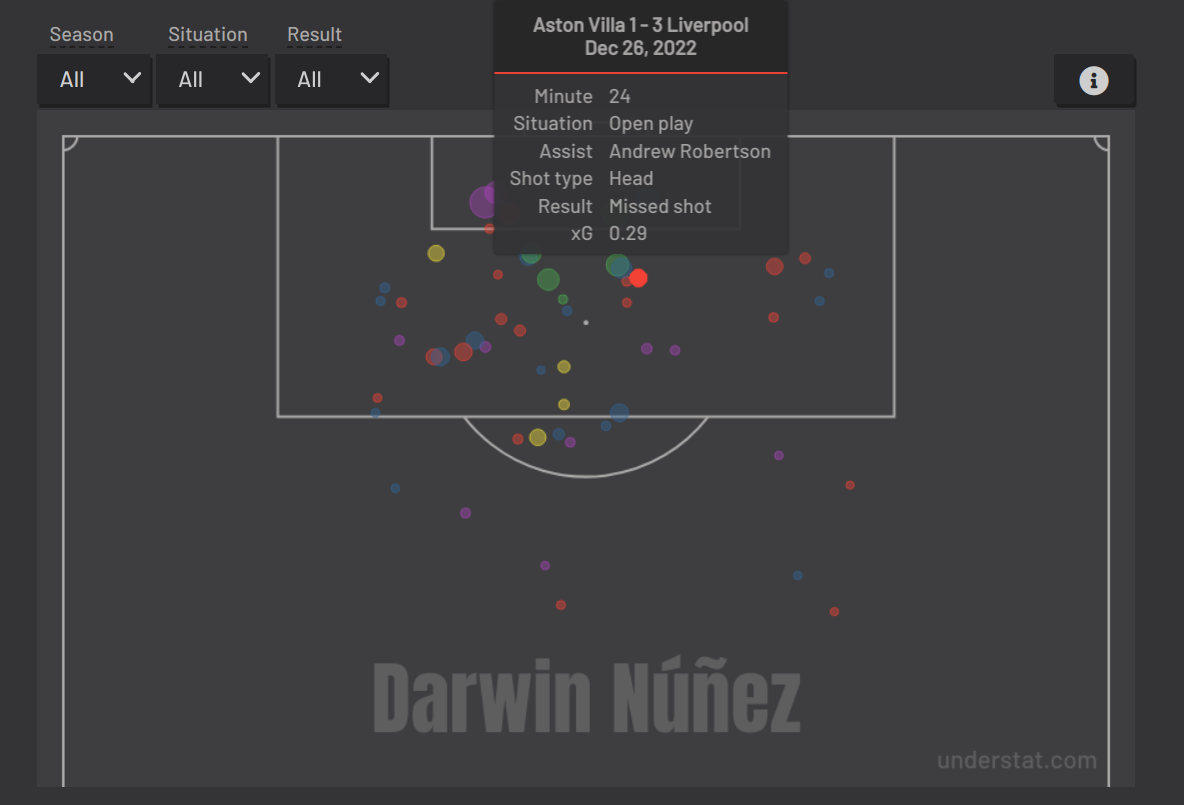

In [5]:
import os
import sys
from httpx import AsyncClient
module_path = os.path.abspath(os.path.join('../transfermarket/'))
sys.path.append(module_path)

In [230]:
nunez_id = '10720'
base_url = 'https://understat.com/player/'

client=AsyncClient()


curl request to mimic

```curl 'https://understat.com/player/10720' \
  -H 'authority: understat.com' \
  -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' \
  -H 'accept-language: en-US,en;q=0.9' \
  -H 'cache-control: max-age=0' \
  -H 'cookie: PHPSESSID=f5c739c911d7d130ad9e5150ed5b8938; UID=a84486e18935c9cf; _ga=GA1.2.1581055568.1673124698; _gid=GA1.2.1765637446.1673124698; beget=begetok; _gat=1; PROMOTIONS=eyI3Ijp7InZpZXdzIjoyLCJjbGlja3MiOjB9LCJkYXRldGltZSI6MTY3MzEzMDg0ODM3MH0=' \
  -H 'referer: https://understat.com/team/Liverpool/2022' \
  -H 'sec-ch-ua: "Not?A_Brand";v="8", "Chromium";v="108", "Google Chrome";v="108"' \
  -H 'sec-ch-ua-mobile: ?0' \
  -H 'sec-ch-ua-platform: "Linux"' \
  -H 'sec-fetch-dest: document' \
  -H 'sec-fetch-mode: navigate' \
  -H 'sec-fetch-site: same-origin' \
  -H 'sec-fetch-user: ?1' \
  -H 'upgrade-insecure-requests: 1' \
  -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36' \
  --compressed```

In [231]:
res = await client.get(base_url)
res.content

b"<html><head><script>function set_cookie(){var now = new Date();var time = now.getTime();time += 19360000 * 1000;now.setTime(time);document.cookie='beget=begetok'+'; expires='+now.toGMTString()+'; path=/';}set_cookie();location.reload();;</script></head><body></body></html>\n"

In [147]:
# according to res above on inital request we have to do this lol
client.cookies.set("beget", "begetok")
nunez_page = await client.get(base_url+nunez_id)

In [150]:
import re
import json

shots_data = re.findall(b"var shotsData \t= JSON.parse\('(.*)'\)", nunez_page.content)[0]
shots = json.loads(shots_data.decode("unicode-escape"))

In [305]:
import pandas as pd
xg_df = pd.DataFrame(shots)

In [306]:
xg_df.columns

Index(['id', 'minute', 'result', 'X', 'Y', 'xG', 'player', 'h_a', 'player_id',
       'situation', 'season', 'shotType', 'match_id', 'h_team', 'a_team',
       'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction'],
      dtype='object')

<AxesSubplot: >

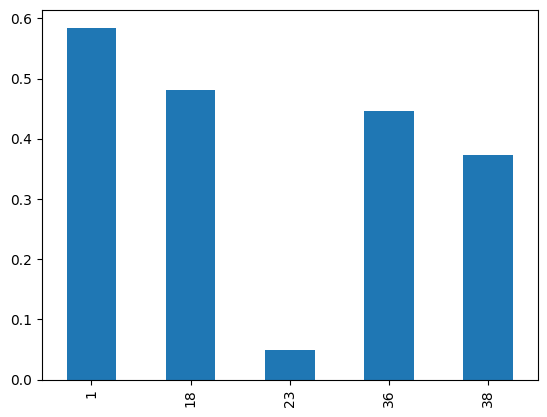

In [307]:
xg_df['xG'] = pd.to_numeric(xg_df['xG'])
xg_df[xg_df['result']=='Goal']['xG'].plot(kind='bar')

<AxesSubplot: >

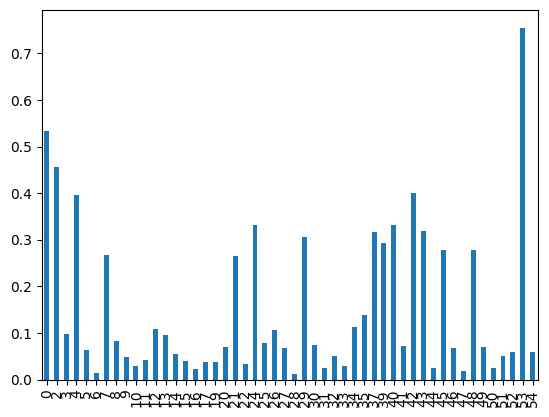

In [308]:
xg_df[xg_df['result']!='Goal']['xG'].plot(kind='bar')

In [309]:
xg_df= xg_df.reset_index(drop=True)

This looks like it'll work well for multiple players

<AxesSubplot: xlabel='xG', ylabel='player'>

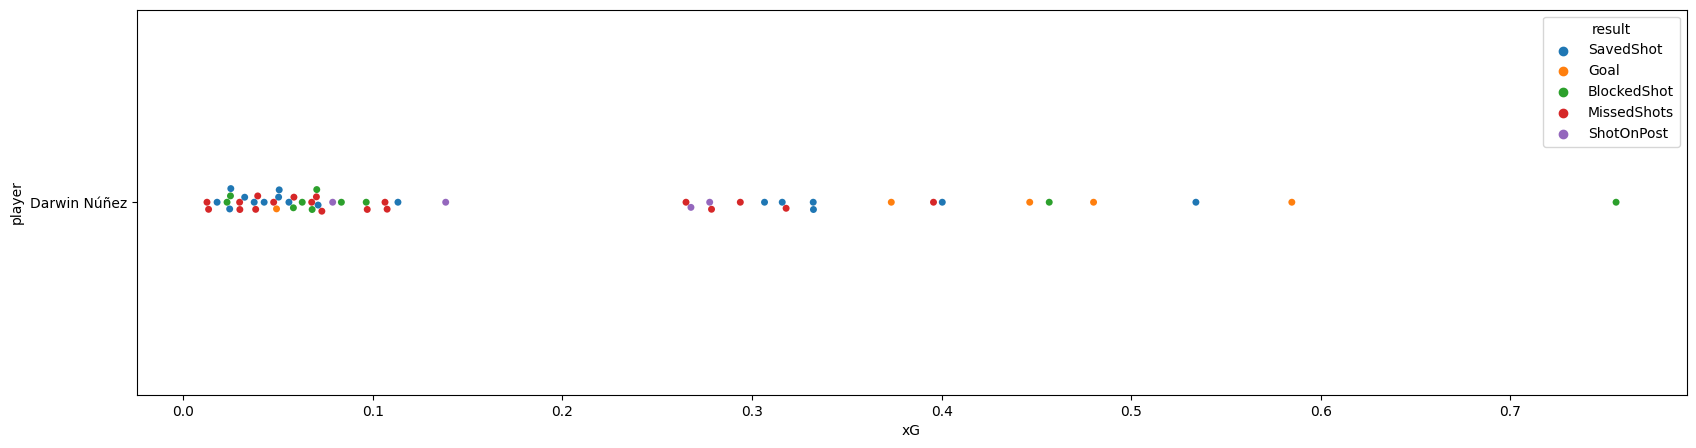

In [310]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))

sns.swarmplot(xg_df,x= 'xG', y='player', hue='result')


Get rid of noise - lets just see goals vs non goal shots

In [311]:
xg_df['goal'] = xg_df.loc[:,'result'].apply(lambda x: x == 'Goal')
xg_df = xg_df[['player', 'xG', 'goal']]
xg_df.head()

,player,xG,goal
0,Darwin Núñez,0.534129,False
1,Darwin Núñez,0.584721,True
2,Darwin Núñez,0.456764,False
3,Darwin Núñez,0.097082,False
4,Darwin Núñez,0.395735,False


<AxesSubplot: xlabel='xG', ylabel='player'>

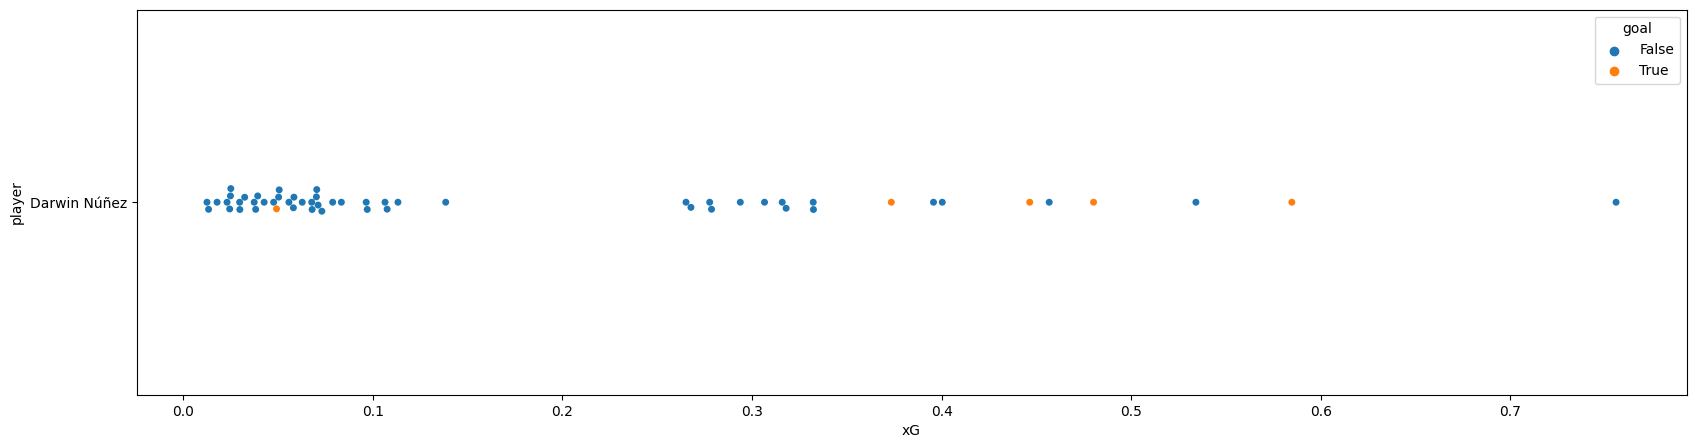

In [312]:
fig, ax = plt.subplots(figsize=(20,5))
sns.swarmplot(xg_df,x= 'xG', y='player', ax=ax, hue='goal')

Let's compare with some other forwards

In [245]:
res = await client.get("https://understat.com/league/EPL")

In [260]:
re.findall(b"var playersData\t= JSON.parse\((.*)\)", res.content)

[b"'\\x5B\\x7B\\x22id\\x22\\x3A\\x228260\\x22,\\x22player_name\\x22\\x3A\\x22Erling\\x20Haaland\\x22,\\x22games\\x22\\x3A\\x2216\\x22,\\x22time\\x22\\x3A\\x221324\\x22,\\x22goals\\x22\\x3A\\x2221\\x22,\\x22xG\\x22\\x3A\\x2215.81395536661148\\x22,\\x22assists\\x22\\x3A\\x223\\x22,\\x22xA\\x22\\x3A\\x223.7190108709037304\\x22,\\x22shots\\x22\\x3A\\x2265\\x22,\\x22key_passes\\x22\\x3A\\x2216\\x22,\\x22yellow_cards\\x22\\x3A\\x223\\x22,\\x22red_cards\\x22\\x3A\\x220\\x22,\\x22position\\x22\\x3A\\x22F\\x20S\\x22,\\x22team_title\\x22\\x3A\\x22Manchester\\x20City\\x22,\\x22npg\\x22\\x3A\\x2218\\x22,\\x22npxG\\x22\\x3A\\x2213.530448451638222\\x22,\\x22xGChain\\x22\\x3A\\x2215.309691175818443\\x22,\\x22xGBuildup\\x22\\x3A\\x220.9555932022631168\\x22\\x7D,\\x7B\\x22id\\x22\\x3A\\x22647\\x22,\\x22player_name\\x22\\x3A\\x22Harry\\x20Kane\\x22,\\x22games\\x22\\x3A\\x2218\\x22,\\x22time\\x22\\x3A\\x221614\\x22,\\x22goals\\x22\\x3A\\x2215\\x22,\\x22xG\\x22\\x3A\\x2211.978790000081062\\x22,\\x22assist

In [261]:
players_data = re.findall(b"var playersData\t= JSON.parse\('(.*)'\)", res.content)[0]
players = json.loads(players_data.decode("unicode-escape"))

In [265]:
players_5_goals = [player for player in players if int(player['goals'])>4]

In [267]:
player_ids = [player['id'] for player in players_5_goals]

In [282]:
import asyncio

fetch_coros = []
for player_id in player_ids:
    fetch_coros.append(client.get(base_url+player_id))

xg_responses = await asyncio.gather(*fetch_coros)


In [288]:
xg_data = []

for res in xg_responses:
    shots_data = re.findall(b"var shotsData \t= JSON.parse\('(.*)'\)", res.content)[0]
    shots = json.loads(shots_data.decode("unicode-escape"))
    xg_df = pd.DataFrame(shots)

    xg_data.append(xg_df)

In [338]:
all_shots = pd.concat(xg_data)

all_shots['xG'] = pd.to_numeric(all_shots['xG'])

In [339]:
all_shots['date'] = pd.to_datetime(all_shots['date'])

In [340]:
from datetime import datetime
all_shots_22_23 = all_shots[all_shots['date'] > datetime(2022,8,1)]

In [341]:
all_shots_22_23['goal'] = all_shots_22_23.loc[:,'result'].apply(lambda x: x == 'Goal')
all_shots_22_23 = all_shots_22_23.loc[:,['player', 'xG', 'goal']]
all_shots_22_23.head()

/tmp/ipykernel_30842/2563592082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_shots_22_23.loc[:, 'goal'] = all_shots_22_23.loc[:,'result'].apply(lambda x: x == 'Goal')


,player,xG,goal
205,Erling Haaland,0.484085,False
206,Erling Haaland,0.761169,True
207,Erling Haaland,0.328053,True
208,Erling Haaland,0.526608,False
209,Erling Haaland,0.066443,False


Looks a bit too crowded, lets remove some players

<AxesSubplot: xlabel='xG', ylabel='player'>

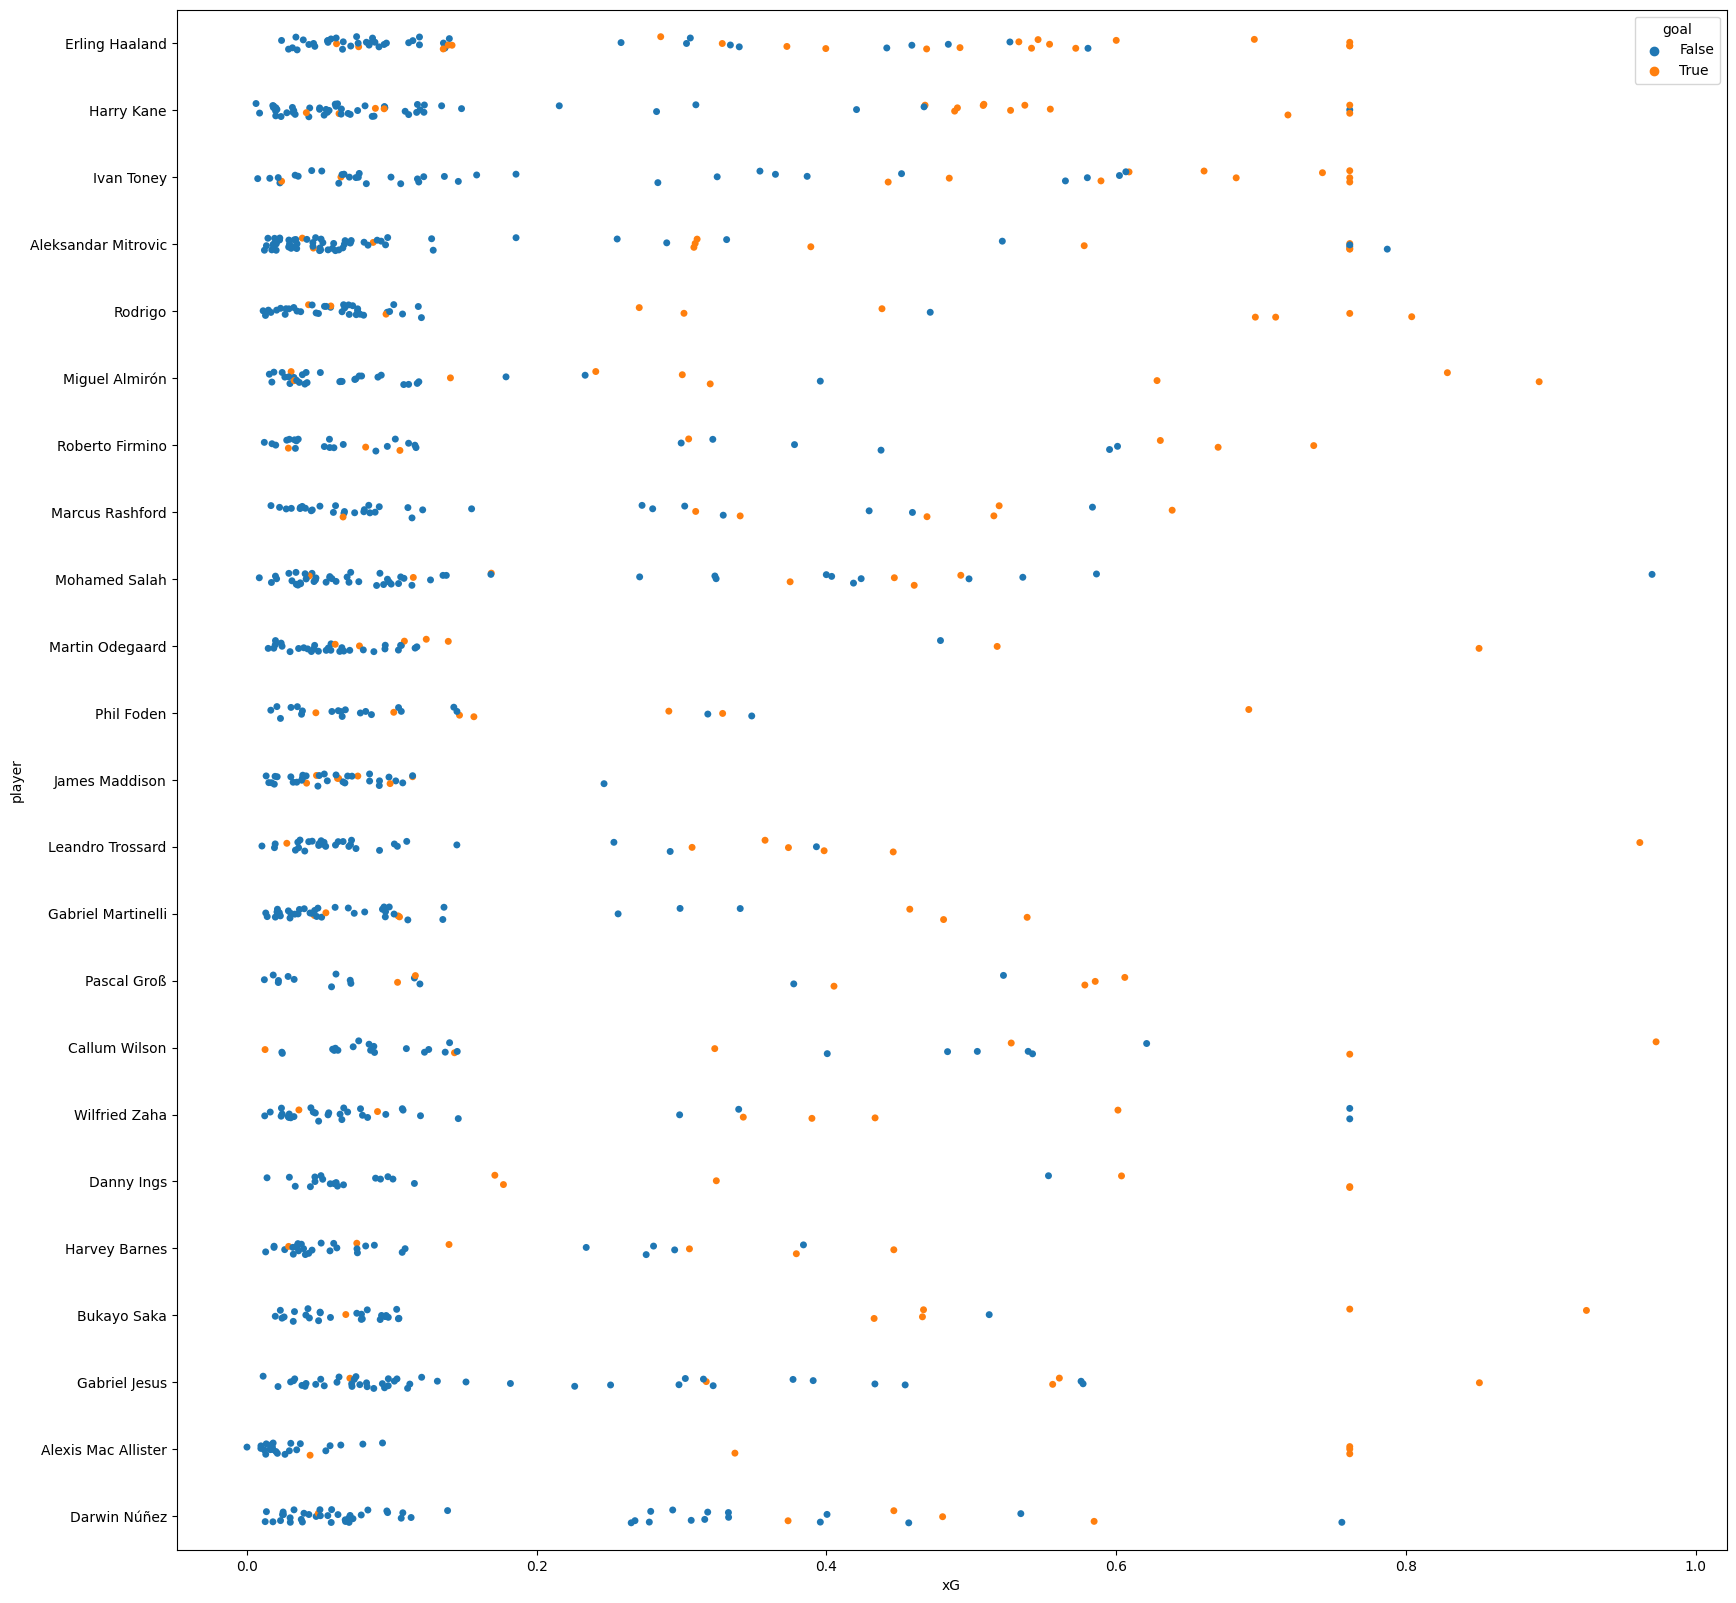

In [343]:
fig, ax = plt.subplots(figsize=(20,20))
sns.stripplot(all_shots_22_23,x= 'xG', y='player', hue='goal', ax=ax)

In [344]:
all_shots_22_23['player'].unique()

array(['Erling Haaland', 'Harry Kane', 'Ivan Toney',
       'Aleksandar Mitrovic', 'Rodrigo', 'Miguel Almirón',
       'Roberto Firmino', 'Marcus Rashford', 'Mohamed Salah',
       'Martin Odegaard', 'Phil Foden', 'James Maddison',
       'Leandro Trossard', 'Gabriel Martinelli', 'Pascal Groß',
       'Callum Wilson', 'Wilfried Zaha', 'Danny Ings', 'Harvey Barnes',
       'Bukayo Saka', 'Gabriel Jesus', 'Alexis Mac Allister',
       'Darwin Núñez'], dtype=object)

In [364]:
players = {
    'Darwin Núñez': 0,
    'Erling Haaland': 1, 
    'Harry Kane': 2,
    'Ivan Toney': 3,
    'Marcus Rashford': 4, 
    'Gabriel Jesus': 5,
    'Mohamed Salah': 6,
    'Roberto Firmino': 7, 
}

relevant_players = all_shots_22_23[all_shots_22_23['player'].apply(lambda x:x in players)]

In [ ]:
relevant_players['order'] = relevant_players.loc['player'].map(players)
relevant_players.sort_values('order', inplace=True)

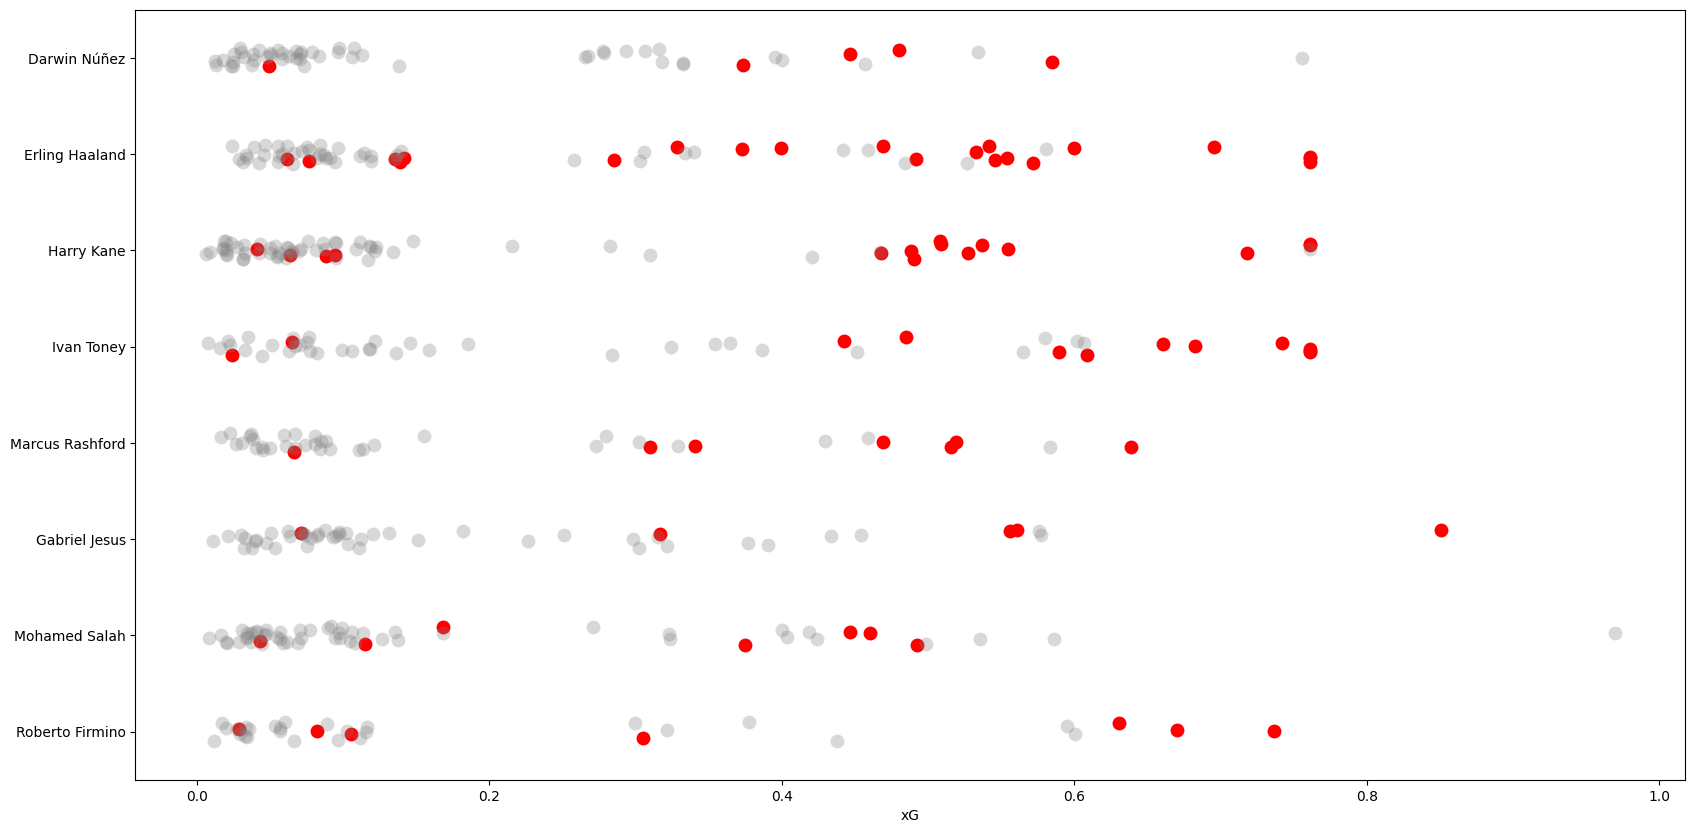

In [383]:
fig, ax = plt.subplots(figsize=(20,10))
sns.stripplot(relevant_players[relevant_players['goal']==True],x= 'xG', y='player', ax=ax, s=10, color='red')
sns.stripplot(relevant_players[relevant_players['goal']==False],x= 'xG', y='player', ax=ax, alpha=0.3, s=10, color='grey')

_ = ax.set_ylabel("")